## Program 4.4 Multi-host SIR model (R using deSolve)

*Author*: Timothy M Pollington @t-pollington

*Date*: 2018-10-03

# Simulation

In [1]:
library(deSolve) #lsoda()
library(reshape2) #melt()

In [2]:
checkSize = function(param, L, W){
  param_name = deparse(substitute(param))
  param_size = dim(param)
  if(is.null(param_size)){
    print(paste0("Warning: ", param_name," is a scalar value, expanding to size ", L, "x", W, "."))
    param = param*matrix(1,L,W)
    param_size = dim(param)
  }
  else if(param_size[1]== W & param_size[2]==L & W!=L){
    print(paste0("Warning: ", param_name," was given in reverse dimension order, so transposing it before use..."))
    param = t(param)
    param_size = dim(param)
  }
  else if(param_size[1]!=L | param_size[2]!=W){
    print(paste0("Error: Parameter ",param_name," is of size ",param_size[1],"x",param_size[2]," and not ",L, "x",W))
    stop("See above message")
  }
return(param)
}

checkGreaterOrEqual = function(param, bound.l){
  if (sum(param<bound.l)>0) {
    param_name = deparse(substitute(param))
    print(paste0("Error: At least one of the values of ",param_name," is less than ",bound.l))
    stop("See message above")
  }
}

In [3]:
sirODE = function(times,init,params){
  with(as.list(c(params,init)), {
    dXh = nu1-r*(Tr12*Ym+Tr11*Yh)*Xh-mu1*Xh
    dXm = nu2-r*(Tr22*Ym+Tr21*Yh)*Xm-mu2*Xm
    dYh = r*(Tr12*Ym+Tr11*Yh)*Xh-mu1*Yh-gamma1*Yh
    dYm = r*(Tr22*Ym+Tr21*Yh)*Xm-mu2*Ym-gamma2*Ym
    return(list(c(dXh,dXm,dYh,dYm)))
  })
}

In [4]:
program4_4 = function (r=0.5/1e3,Tr=matrix(c(0,0.5,0.8,0),2,2,byrow = TRUE),gamma=c(0.033,0),mu=c(5.5e-5,0.143),nu=c(5.5e-2,1.443e3),X0=c(1e3,1e4),Y0=c(1,1),max_time=1000){
  # Function contains default arguments if run as program4_4()
    
  # Check lengths/dimensions of inputs
  r = ifelse(length(r)==1,r,stop("r is not a scalar."))
  max_time = ifelse(length(max_time)==1,max_time,stop("max_time is not a scalar."))
  Tr = checkSize(Tr,2,2)
  gamma = checkSize(gamma,1,2)
  mu = checkSize(mu,1,2)
  nu = checkSize(nu,1,2)
  X0 = checkSize(X0,1,2)
  Y0 = checkSize(Y0,1,2)
  
  # Check parameter values are valid
  checkGreaterOrEqual(r,0)
  checkGreaterOrEqual(max_time,0)
  checkGreaterOrEqual(Tr,0)
  checkGreaterOrEqual(gamma,0)
  checkGreaterOrEqual(mu,0)
  checkGreaterOrEqual(nu,0)
  checkGreaterOrEqual(X0,0)
  checkGreaterOrEqual(Y0,0)
  
  if (Tr[1,1]!=0 | Tr[2,2]!=0) {
    print("Warning: Transmission probability between human-human or mosquito-mosquito species (i.e. T's diagonal) is non-zero'") # We print this warning as it is unusual to have non-zero T_HH & T_MM for basic vector models.
  }
  if (Tr[1,1]<0 | Tr[1,1]>1) {
    stop("Human-to-human transmission probability is not between zero and 1.")
  }
  if (Tr[2,2]<0 | Tr[2,2]>1) {
    stop("Mosquito-to-mosquito transmission probability is not between zero and 1.")
  }
  if (Tr[1,2]<0 | Tr[1,2]>1) {
    stop("Human-to-mosquito transmission probability is not between zero and 1.")
  }
  if (Tr[2,1]<0 | Tr[2,1]>1) {
    stop("Mosquito-to-human transmission probability is not between zero and 1.")
  }

  # ODE solver
  params = c(nu[1],nu[2],r,Tr[1,1],Tr[1,2],Tr[2,1],Tr[2,2],mu[1],mu[2],gamma[1],gamma[2])
  names(params) = c("nu1","nu2","r","Tr11","Tr12","Tr21","Tr22","mu1","mu2","gamma1","gamma2")
  init = c(X0[1],X0[2],Y0[1],Y0[2]) 
  names(init) = c("Xh","Xm","Yh","Ym")
  times = seq(0,max_time,length.out=(max_time+1))
  sir_out = lsoda(init,times,sirODE,params,rtol = 1e-5) # rtol matches the original MATLAB code   
  return(sir_out)
}    

In [5]:
sir_out = program4_4() #Reproduces Keeling & Rohani's results as seen in their original MATLAB code.

[1] "Warning: gamma is a scalar value, expanding to size 1x2."
[1] "Warning: mu is a scalar value, expanding to size 1x2."
[1] "Warning: nu is a scalar value, expanding to size 1x2."
[1] "Warning: X0 is a scalar value, expanding to size 1x2."
[1] "Warning: Y0 is a scalar value, expanding to size 1x2."


# Benchmarking

In [6]:
tic = proc.time()
invisible(program4_4()) # invisible() hides function output, apart from warnings
proc.time() - tic # ~0.1 secs on Dell Precision M2800 laptop

[1] "Warning: gamma is a scalar value, expanding to size 1x2."
[1] "Warning: mu is a scalar value, expanding to size 1x2."
[1] "Warning: nu is a scalar value, expanding to size 1x2."
[1] "Warning: X0 is a scalar value, expanding to size 1x2."
[1] "Warning: Y0 is a scalar value, expanding to size 1x2."


   user  system elapsed 
  0.278   0.000   0.278 

# Visualisation

In [7]:
library(ggplot2)
library(gridExtra)

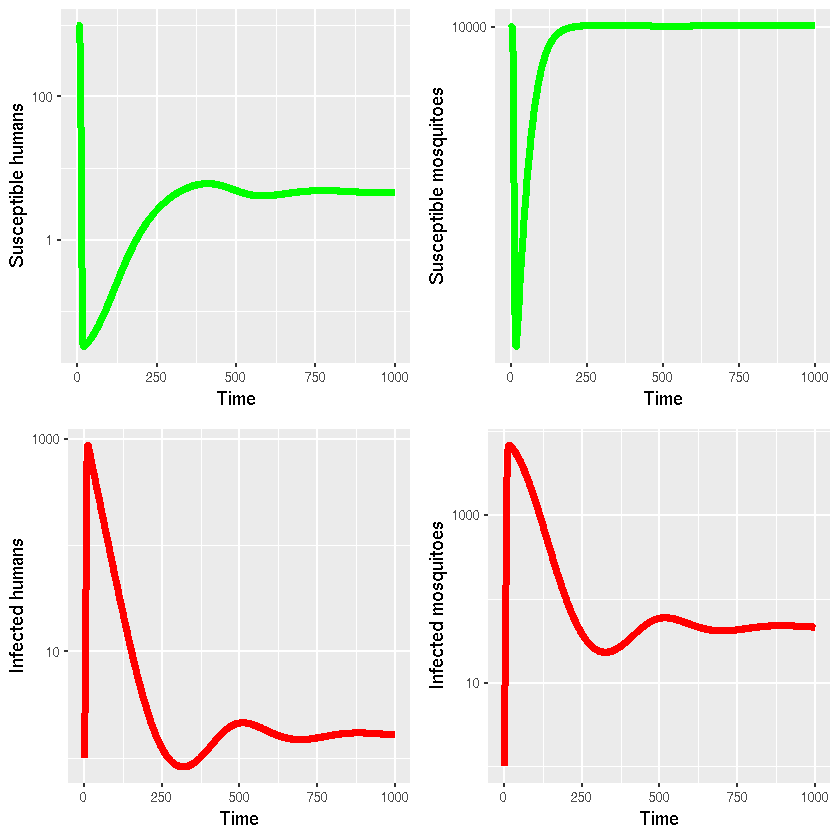

In [8]:
g1 = ggplot(as.data.frame(sir_out[,c(1,2)]),aes(x=time,y=Xh))+
  geom_line(lwd=2,colour="green")+
  xlab("Time")+ylab("Susceptible humans")+
  scale_y_log10()
g2 = ggplot(as.data.frame(sir_out[,c(1,3)]),aes(x=time,y=Xm))+
  geom_line(lwd=2,colour="green")+
  xlab("Time")+ylab("Susceptible mosquitoes")+
  scale_y_log10()
g3 = ggplot(as.data.frame(sir_out[,c(1,4)]),aes(x=time,y=Yh))+
  geom_line(lwd=2,colour="red")+
  xlab("Time")+ylab("Infected humans")+
  scale_y_log10()
g4 = ggplot(as.data.frame(sir_out[,c(1,5)]),aes(x=time,y=Ym))+
  geom_line(lwd=2,colour="red")+
  xlab("Time")+ylab("Infected mosquitoes")+
  scale_y_log10()
grid.arrange(g1, g2, g3, g4, ncol=2) #Reproduces Keeling & Rohani's plots as seen in their original MATLAB code.